## Multimode Interferometer (MMI)

Soldano, L. B. & Pennings, E. C. M. Optical multi-mode interference devices based on self-imaging: principles and applications. Journal of Lightwave Technology 13, 615–627 (1995).
https://ieeexplore.ieee.org/document/372474

In [75]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

plt.style.use(r"C:\Users\B30724\Documents\Python\presentation.mplstyle")

In [76]:
def mode_equation(neff, m, nr, ns, width, k0, mode=0):
    
    a = width / 2
    h = k0*np.sqrt(nr**2 - neff**2)  # Inverse for spatial periodicity in waveguide, decreasing as neff increases
    g = k0*np.sqrt(neff**2 - ns**2)  # Inverse for decay into cladding, increasing as neff increases
    
    with np.errstate(divide='ignore'):
        if mode == 0:
            val = m*np.pi/2 + np.arctan(g/h) - h*a
        elif mode == 2:
            val = m*np.pi/2 + np.arctan(nr**2/ns**2*g/h) - h*a
    
    return val

def calculate_mode(xs, m, nr, ns, width, k0, mode=0):

    mode_eqn = lambda neff: mode_equation(neff, m, nr, ns, width, k0, mode=mode)
    if mode_eqn(ns) > 0:  # mode_eqn(nr) > 0 always true
        return None  # No solution
    else:
        root = root_scalar(mode_eqn, bracket=(ns, nr), x0=nr)
        if root.converged:
            neff = root.root
            x1, x2, x3 = xs  # Stack from bottom (negative x) to top (positive x)
            a = width / 2
            h = k0 * np.sqrt(nr**2 - neff**2)
            g = k0 * np.sqrt(neff**2 - ns**2)
            if m % 2 == 0:
                phi = 0
            else:
                phi = np.pi / 2
            field = [np.cos(h*a+phi)*np.exp(g*(x1+a)),
                     np.cos(h*x2-phi),
                     np.cos(h*a-phi)*np.exp(-g*(x3-a))]
        return (neff, field)
    
def find_modes(xs, nr, ns, width, k0, mode=0, max_mode=10):

    m = 0
    Neff = []
    Field = []
    while (m < max_mode):
        res = calculate_mode(xs, m, nr, ns, width, k0, mode=mode)
        if res is None:
            pass
        else:
            neff, field = res
            Neff.append(neff)
            Field.append(field)
        m += 1

    return (Neff, Field)

In [125]:
width = 2.0e-6  # Width of the multimode waveguide
wavelength = 1.31e-6  # Vacuum wavelength (SI)
nr = 2.994648835482219  # Ridge waveguide effective index (core)
ns = 1.4467245597197314  # Surrounding effective index (cladding)
mode = 2  # 0 for TE (that is actually TM-like mode), 2 for TM (that is actually TE-like mode). Need to be consistant with nr...
max_mode = 20  # Max number of modes to search for eigenvalues

k0 = 2*np.pi/wavelength
a = width / 2
x1 = np.linspace(-5*a, -a, 221)[:-1:]  # Substrate
x2 = np.linspace(-a, a, 111)  # Waveguide
x3 = np.linspace(a, 5*a, 221)[1::]  # Top cladding
x = np.hstack([x1, x2, x3])
Neff, Field = find_modes([x1, x2, x3], nr, ns, width, k0, 
                         mode=mode, max_mode=max_mode)
print("Found", len(Neff), "modes")
print(*Neff, sep='\n')

Found 9 modes
2.9773420741325762
2.924866465154148
2.8354740407332146
2.705956635165685
2.53113374042568
2.3031025673824974
2.0114863224913537
1.661937647284592
1.4467364499231405


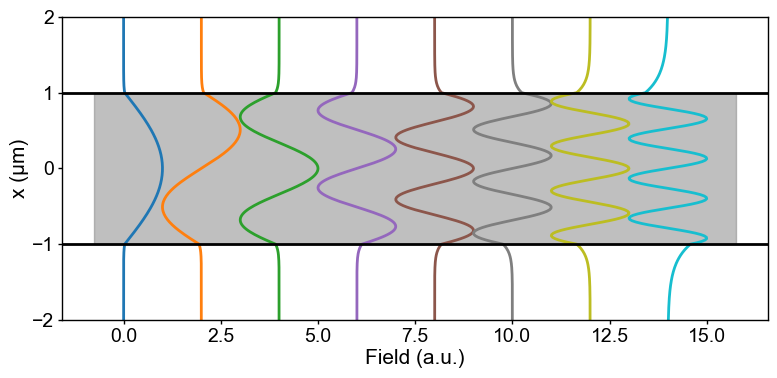

In [84]:
num_mode = 8  # Truncate to this number of modes
color = plt.cm.tab10(np.linspace(0,1,num_mode))

fig, ax = plt.subplots(figsize=(8,4))
shift = 0
for m in range(num_mode):
    field = np.hstack(Field[m])
    ax.plot(field+shift, x*1e6, c=color[m])
    shift += 2*np.abs(field).max()
ax.axhline(a*1e6, c='k')
ax.axhline(-a*1e6, c='k')
ax.fill_between(ax.get_xlim(), a*1e6, -a*1e6, color='gray', alpha=0.5)
ax.set(xlabel="Field (a.u.)", ylabel="x (µm)")
ax.set_ylim([-2*a*1e6, 2*a*1e6])
fig.tight_layout()

### Decomposition of arbitrary field
Given an input beam profile $\psi(x, z=0)$. Assume it is narrow enough not to excite unguided modes, it may be decomposed into guided modes alone:
$$ \psi(x,0) = \sum_{m=0}^{M-1} c_m \psi_m(x) $$

The field profile at a distance $z$ can then be written as a superposition of all the guided mode field distributions:
$$ \psi(x,z) = \sum_{m=0}^{M-1} c_m \psi_m(x) \text{exp}\left[ j(\beta_m z - \omega t)\right] $$

Taking the phase of the fundamental mode as a common factor out of the sum and dropping the time dependence $\text{exp}(-j\omega t)$, the field profile becomes:
$$ \psi(x,z) = \sum_{m=0}^{M-1} c_m \psi_m(x) \text{exp}\left[j(\beta_m-\beta_0)z\right] $$

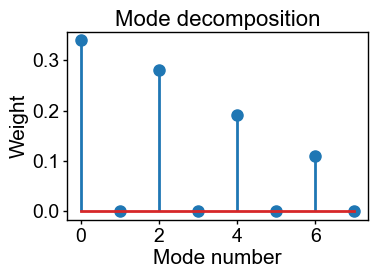

In [117]:
beam_waist = 0.2e-6
off_center = 0  # 0.4e-6
F0 = np.exp(-(x-off_center)**2/beam_waist**2)
Coef = []

for m in range(num_mode):
    field = np.hstack(Field[m])
    power = trapezoid(field**2, x=x)
    c = trapezoid(F0*field, x=x) / power
    Coef.append(c.item())

fig, ax = plt.subplots(figsize=(4,3))
ax.stem(np.arange(num_mode), np.abs(Coef))
ax.set(xlabel="Mode number", ylabel="Weight", title="Mode decomposition")
fig.tight_layout()

### Approximate propagation constant
The lateral ($x$-direction) wavenumber $h_m$ and the propagation constant $\beta_m$ are related to the ridge (effective) index $n_r$ by:
$$ h_m^2 + \beta_m^2 = n_r^2 k^2 $$
where $k=2\pi/\lambda$ is the vacuum wavenumber, and
$$ h_m \approx \frac{(m+1)\pi}{W} $$
where $W$ is the width of the multimode waveguide (for refinement, take into account the lateral penetration depth of each mode field). Assume that $h_m^2 << n_r^2 k^2$, the propagation constants can be deduced:
$$ \begin{align}
\beta_m &\approx n_r k \left(1-\frac{1}{2}\frac{h_m^2}{n_r^2 k^2}\right) \\
&\approx n_r k - \frac{(m+1)^2\pi\lambda}{4n_r W^2}
\end{align} $$

Defining $L_\pi$ as the beat length of the two lowest-order modes:
$$ L_\pi = \frac{\pi}{\beta_0 - \beta_1} \approx \frac{4 n_r W^2}{3 \lambda} $$

The propagation constants spacing can be written as:
$$ (\beta_0 - \beta_m) \approx \frac{m(m+2)\pi}{3 L_\pi} $$

In [122]:
Beta = [neff*k0 for neff in Neff]
Lpi = np.pi / (Beta[0] - Beta[1])
print(f"Beat length of the two lowest modes: {Lpi*1e6:.3f} µm")
Lpi_bis = 4*nr*width**2/(3*wavelength)
print(f"Approximate beat length: {Lpi_bis*1e6:.3f} µm")

Beat length of the two lowest modes: 12.482 µm
Approximate beat length: 12.192 µm


Simplified field profile:
$$ \psi(x,z) \approx \sum_{m=0}^{M-1} c_m \psi_m(x) \text{exp}\left[-j\frac{m(m+2)\pi}{3 L_\pi}z\right] $$

- At $z=p\:3L_\pi$ ($p=2,4,6,...$): field profile is replicate of the input field (direct self-imaging)
$$ \psi(x,z) \approx \psi(x,0) $$

- At $z=p\:3L_\pi$ ($p=1,3,5,...$): field profile is the input field mirrored about $x=0$ (mirrored self-imaging)
$$ \begin{align}
\psi(x,z) &\approx \sum_{m\ \text{even}} c_m \psi_m(x) + \sum_{m\ \text{odd}} -c_m \psi_m(x) \\
&= \psi(-x,0)
\end{align} $$

- At $z=\frac{p}{2}\:3L_\pi$ ($p=1,3,5,...$): the total field at these lengths is found to be twice of input images
$$ \begin{align}
\psi(x,z) &\approx \sum_{m\ \text{even}} c_m \psi_m(x) + \sum_{m\ \text{odd}} j^p c_m \psi_m(x) \\
&= \frac{1+j^p}{2} \psi(x,0) + \frac{1-j^p}{2} \psi(-x,0) 
\end{align} $$

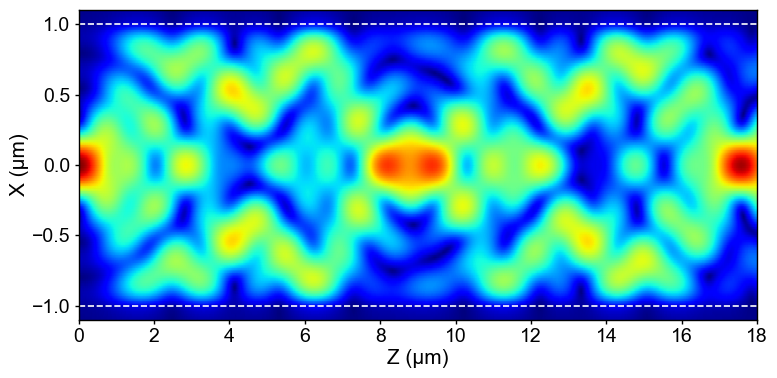

In [121]:
def plot_mmi(x, z, width, num_mode, Beta, Field, Coef):

    F = np.zeros((len(x), len(z)), dtype=complex)
    for m in range(num_mode):
        field = np.hstack(Field[m]).reshape((-1,1))  # Column vector
        propagate = np.exp(1j*(Beta[m]-Beta[0])*z).reshape((1,-1))  # Row vector
        F += Coef[m]*field @ propagate

    xx, zz = np.meshgrid(z*1e6, x*1e6)
    a = width / 2

    fig, ax = plt.subplots(figsize=(8,4))
    ax.pcolormesh(xx, zz, np.abs(F), cmap='jet', shading='gouraud')
    ax.axhline(a*1e6, c='w', ls='--', lw=1.2)
    ax.axhline(-a*1e6, c='w', ls='--', lw=1.2)
    ax.set(xlabel="Z (µm)", ylabel="X (µm)")
    ax.set_ylim([-a*1.1e6, a*1.1e6])
    fig.tight_layout()

plot_mmi(x, np.linspace(0, 18e-6, 1000), width, num_mode, Beta, Field, Coef)